# Taxi Fare Prediction Modeling


### Introduction
The objective of this study is to develop a predictive model for taxi fares using the NYC yellow taxi trip dataset from 2023. The goal is to identify key factors influencing fare amounts and leverage machine learning techniques to create a model that accurately estimates fares. This model aims to provide a structured fare system for Tbilisi, Georgia.

### Summary of EDA Insights and Hypotheses
Key insights from the exploratory data analysis include:
- Fare amount, trip distance, trip duration, speed, and tip amount distributions are highly right-skewed, necessitating transformations.
- Fare amount has strong positive correlations with trip distance and trip duration.
- Time of day, day type, season, and holidays significantly impact fare amounts.
- Proper handling of outliers is crucial for accurate model predictions.

Hypotheses:
1. Longer trip distances and durations result in higher fares.
2. Fares vary by time of day, day of the week, and season, with peaks during special events and holidays.
3. Higher average speeds may correlate with higher fares due to longer distances covered in shorter times.
4. Higher fares tend to receive higher tips.



In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
# KNN with reduced dimensions
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

## Functions Used 

In [2]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df



In [3]:
# Function for log transformation handling zeros
def log_transform_with_zeros(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])  # Adding 1 to handle zeros
    return df

In [4]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()

In [5]:
def plot_residuals(y_test, residuals, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Residuals Distribution for {model_name}')
    plt.show()

In [7]:
def plot_distributions(df, numeric_features):
    """
    Plot the distributions of numeric features in the dataframe.

    Parameters:
    df (DataFrame): The dataframe containing the features.
    numeric_features (list): List of numeric feature names to plot.
    """
    plt.figure(figsize=(20, len(numeric_features) * 6))  # Adjust figure size based on the number of features
    
    for i, feature in enumerate(numeric_features):
        plt.subplot(len(numeric_features), 1, i + 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## DATA LOADING 

In [8]:
# Load the dataset
df = pd.read_parquet('sampled_taxi_dataset_v.1.parquet')
df.head()

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,distance_bins,pickup_time_of_day,pickup_season,passenger_count_category,pickup_day_type,transaction_month,trip_duration,trip_duration_hours,PUcategory,DOcategory,is_holiday,speed_mph
21588994,1,16.60,1,67.4,16.00,10-20 miles,afternoon,autumn,low,weekday,10,46.950000,0.782500,Airport,Suburbs,0,21.214058
23139565,1,15.80,1,61.1,5.00,10-20 miles,afternoon,autumn,low,weekend,10,40.133333,0.668889,Airport,Suburbs,0,23.621262
18758042,3,17.62,1,84.2,0.10,10-20 miles,afternoon,autumn,medium,weekday,9,77.683333,1.294722,Airport,Suburbs,0,13.609097
19435420,1,11.16,1,53.4,13.87,10-20 miles,afternoon,autumn,low,weekend,9,47.883333,0.798056,Airport,City Center,0,13.983989
19850690,2,8.17,1,41.5,10.45,5-10 miles,afternoon,autumn,medium,weekday,9,34.400000,0.573333,Airport,City Center,0,14.250000


In [9]:
# Features to retain
features_to_retain = [
    'trip_distance', 'trip_duration', 'speed_mph', 'tip_amount', 
    'pickup_time_of_day', 'pickup_day_type', 'pickup_season', 
    'is_holiday', 'PUcategory', 'DOcategory', 'fare_amount'
]

# Retain only the necessary features
df = df[features_to_retain]
df.head()


,trip_distance,trip_duration,speed_mph,tip_amount,pickup_time_of_day,pickup_day_type,pickup_season,is_holiday,PUcategory,DOcategory,fare_amount
21588994,16.60,46.950000,21.214058,16.00,afternoon,weekday,autumn,0,Airport,Suburbs,67.4
23139565,15.80,40.133333,23.621262,5.00,afternoon,weekend,autumn,0,Airport,Suburbs,61.1
18758042,17.62,77.683333,13.609097,0.10,afternoon,weekday,autumn,0,Airport,Suburbs,84.2
19435420,11.16,47.883333,13.983989,13.87,afternoon,weekend,autumn,0,Airport,City Center,53.4
19850690,8.17,34.400000,14.250000,10.45,afternoon,weekday,autumn,0,Airport,City Center,41.5


## 1. Removing Outliers Observed During EDA

We will use IQR method to remove outliers observed in our EDA notebook as they will influence our models and for better model predictions we will ensure they are clean.

In [10]:
# Define numerical features to check for outliers
numerical_features = ['fare_amount', 'trip_distance', 'trip_duration', 'speed_mph', 'tip_amount']

# Remove outliers
df_cleaned = remove_outliers(df, numerical_features)
df_cleaned.head()


,trip_distance,trip_duration,speed_mph,tip_amount,pickup_time_of_day,pickup_day_type,pickup_season,is_holiday,PUcategory,DOcategory,fare_amount
19861556,3.78,16.433333,13.801217,7.46,afternoon,weekday,autumn,0,Airport,Suburbs,19.1
20389403,3.44,13.150000,15.695817,4.98,afternoon,weekday,autumn,0,Airport,Suburbs,18.4
22548453,1.94,8.800000,13.227273,0.00,afternoon,weekend,autumn,0,Airport,Airport,12.1
22368807,5.47,22.400000,14.651786,7.16,afternoon,weekday,autumn,0,Airport,Suburbs,26.8
20320646,2.94,11.083333,15.915789,5.53,afternoon,weekday,autumn,0,Airport,Suburbs,15.6


In [66]:
print(len(df)-len(df_cleaned))
print('outliers removed')

68986
outliers removed


### Visualising Residual Outliers

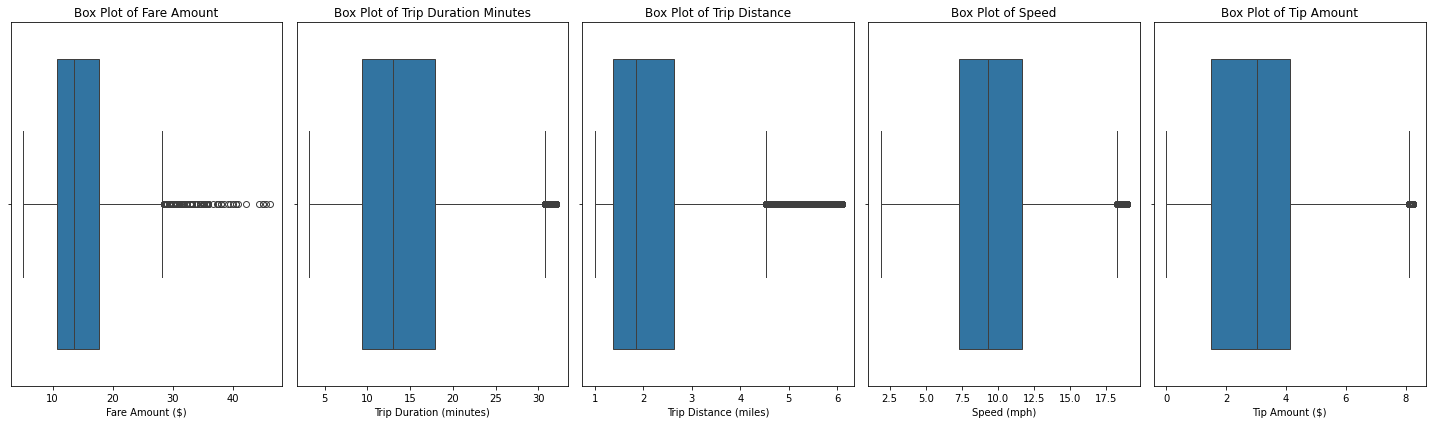

In [12]:
# Set the size of the entire figure
plt.figure(figsize=(20, 6))

# Create a subplot for the fare amount
plt.subplot(1, 5, 1)  # 1 row, 5 columns, 1st subplot
sns.boxplot(x=df_cleaned['fare_amount'])
plt.title('Box Plot of Fare Amount')
plt.xlabel('Fare Amount ($)')

# Create a subplot for the trip duration
plt.subplot(1, 5, 2)  # 1 row, 5 columns, 2nd subplot
sns.boxplot(x=df_cleaned['trip_duration'])
plt.title('Box Plot of Trip Duration Minutes')
plt.xlabel('Trip Duration (minutes)')

# Create a subplot for the trip distance
plt.subplot(1, 5, 3)  # 1 row, 5 columns, 3rd subplot
sns.boxplot(x=df_cleaned['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance (miles)')

# Create a subplot for the speed
plt.subplot(1, 5, 4)  # 1 row, 5 columns, 4th subplot
sns.boxplot(x=df_cleaned['speed_mph'])
plt.title('Box Plot of Speed')
plt.xlabel('Speed (mph)')

# Create a subplot for the tip amount
plt.subplot(1, 5, 5)  # 1 row, 5 columns, 5th subplot
sns.boxplot(x=df_cleaned['tip_amount'])
plt.title('Box Plot of Tip Amount')
plt.xlabel('Tip Amount ($)')

# Display the plot
plt.tight_layout()

We can observe that the cleaning was succesful and that outliers were removed, we do see that some outliers remaind but to avoid overfitting and unrealistic results we will retain thos outliers. 

## 2. Transforming Numeric Features 

As we saw numeric features we want to use are righ skewed are not normally distributed thus log transofrmation is a good step to ensure predictive power of the model.

## 2.1 Transforming Trip Durations
We tried applying log transformation that did not work on the trip durations thus we decided to use box_cox transformations.

In [13]:
# Apply Box-Cox transformation
df_cleaned['boxcox_trip_duration'], _ = boxcox(df_cleaned['trip_duration'] + 1)  # Adding 1 to handle zero values
# Apply robust scaling to boxcox_trip_duration
scaler = RobustScaler()
df_cleaned['scaled_boxcox_trip_duration'] = scaler.fit_transform(df_cleaned[['boxcox_trip_duration']])


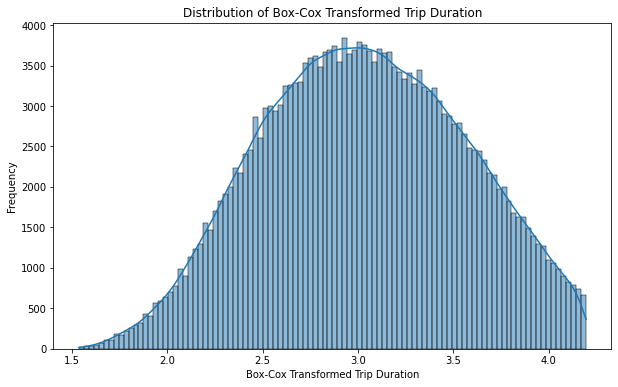

In [14]:

# Visualize the new feature
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['boxcox_trip_duration'], kde=True)
plt.title('Distribution of Box-Cox Transformed Trip Duration')
plt.xlabel('Box-Cox Transformed Trip Duration')
plt.ylabel('Frequency')
plt.show()

### 2.2 Tip Amounts 

Tip amounts need seprate handling as there are so many trips with 0 tips and this affects the distribution thus we used robust scaler that is better at scaling and transforming data and handles 0 on negative values better than log transfromation. 


In [15]:
# Create a binary feature for whether a trip has a tip
df_cleaned['has_tip'] = (df_cleaned['tip_amount'] > 0).astype(int)

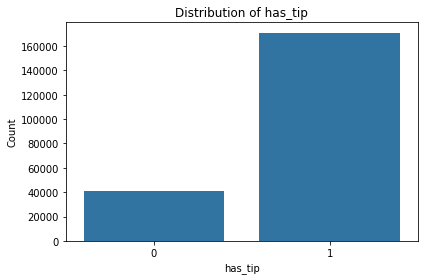

In [16]:
# Plot the distribution for 'has_tip'
sns.countplot(x='has_tip', data=df_cleaned)
plt.title('Distribution of has_tip')
plt.xlabel('has_tip')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
# Replace zero tips with a different small constant value
df_cleaned['tip_amount'] = df_cleaned['tip_amount'].replace(0, 0.001)  # Example alternative constant

# Apply log transformation to non-zero tips
df_cleaned['log_tip_amount'] = np.log1p(df_cleaned['tip_amount'])

# Apply robust scaling to log-transformed tips
scaler = RobustScaler()
df_cleaned['scaled_tip_amount'] = scaler.fit_transform(df_cleaned[['log_tip_amount']])





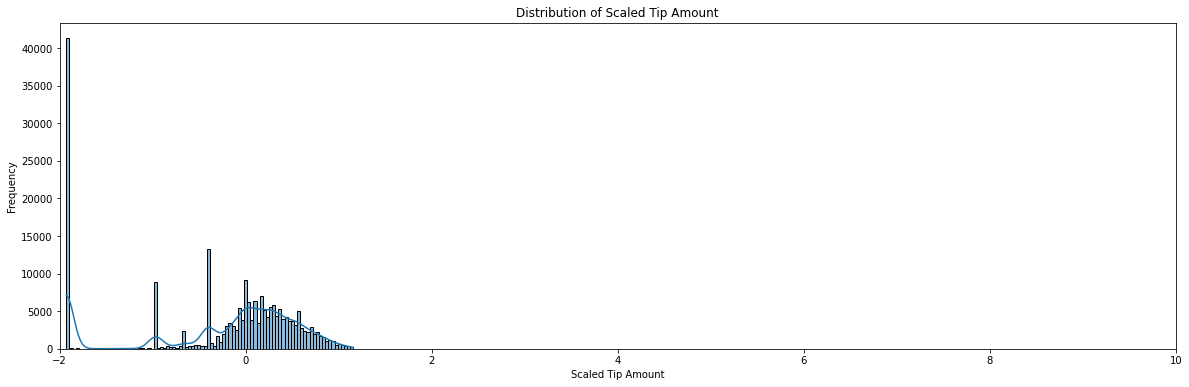

In [18]:
# Visualize the new distribution
plt.figure(figsize=(20, 6))
sns.histplot(df_cleaned['scaled_tip_amount'], kde=True)
plt.title('Distribution of Scaled Tip Amount')
plt.xlabel('Scaled Tip Amount')
plt.ylabel('Frequency')
plt.xlim(-2, 10)  # Adjust x-axis range for better visualization
plt.show()

# Removing tip_amount as a Feature
Given the challenges with normalizing the tip_amount feature, it might be reasonable to consider removing it, especially if:

Model Performance: If the inclusion of tip_amount does not significantly improve the model's performance.
Feature Importance: If the feature importance analysis shows that tip_amount is not a significant predictor of fare_amount.
Correlation: If tip_amount is not strongly correlated with fare_amount.

On the contrary tip amount and fare are higly correlated but tip amount is determined through fare not the otehr way around thus tip amount cannot be a good predictor for fare amounts.

In [19]:
# Drop the original tip_amount column
df_cleaned = df_cleaned.drop(columns=['tip_amount'])

### 2.3 Log Transfroming Rest Of Numerical Features

In [20]:
# Apply log transformation to skewed numerical features
df = log_transform_with_zeros(df, ['fare_amount','speed_mph','trip_distance'])

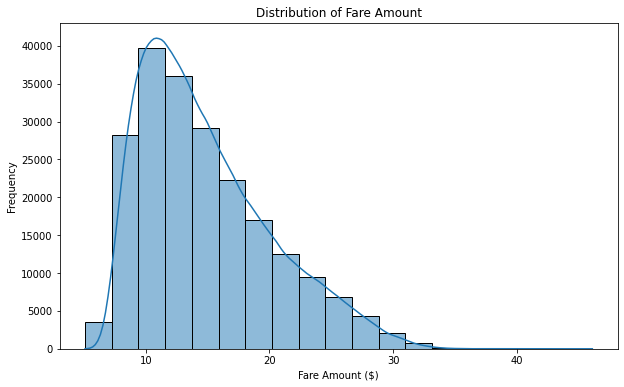

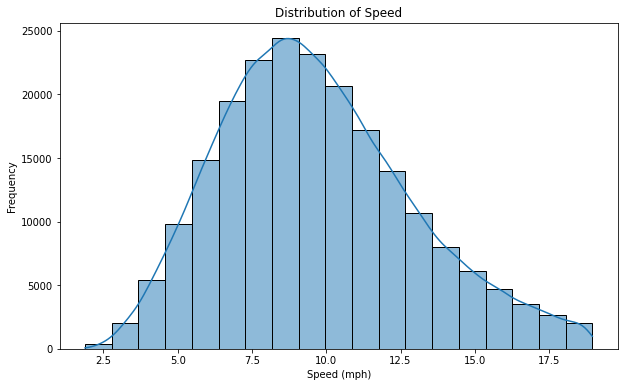

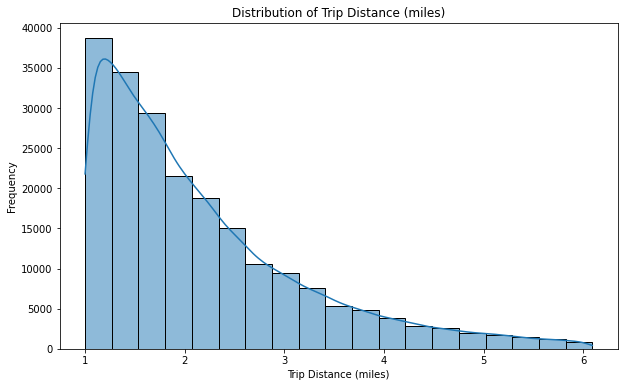

In [21]:
# Fare Amount
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['fare_amount']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['fare_amount'], bins=num_bins, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Speed
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['speed_mph']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['speed_mph'], bins=num_bins, kde=True)
plt.title('Distribution of Speed')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.show()

# Trip Distance
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['trip_distance']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['trip_distance'], bins=num_bins, kde=True)
plt.title('Distribution of Trip Distance (miles)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

Log transformation did not do much for fare amount and trip distance thus we will use box-cox transformation


## Final Visualisation 

We see that transformations worked we can observe still slight skewness for tip amounts but models should be able to handle this.

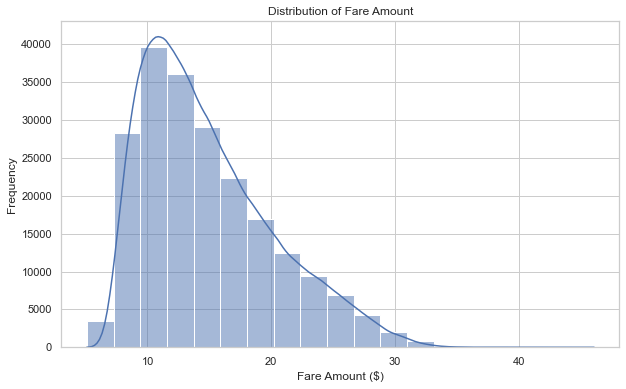

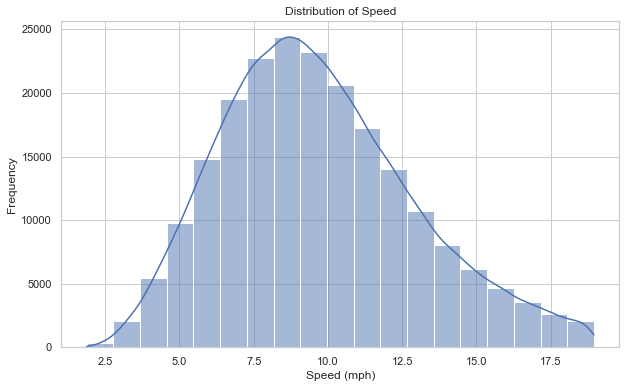

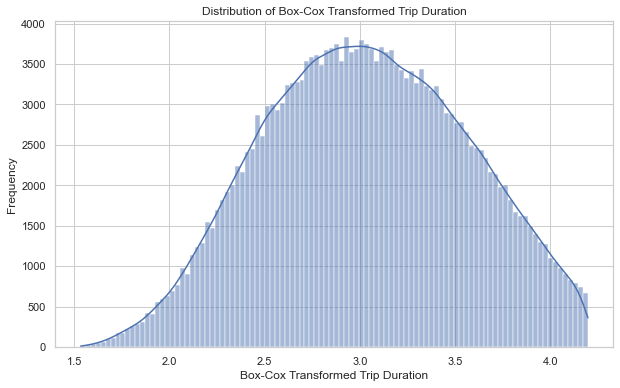

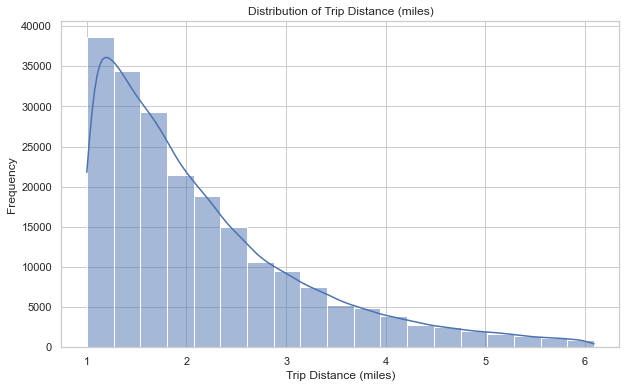

In [22]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting distributions with correct number of bins and settings

# Fare Amount
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['fare_amount']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['fare_amount'], bins=num_bins, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Speed
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['speed_mph']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['speed_mph'], bins=num_bins, kde=True)
plt.title('Distribution of Speed')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.show()

# Visualize  Trip Duration
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['boxcox_trip_duration'], kde=True)
plt.title('Distribution of Box-Cox Transformed Trip Duration')
plt.xlabel('Box-Cox Transformed Trip Duration')
plt.ylabel('Frequency')
plt.show()


# Trip Distance
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['trip_distance']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['trip_distance'], bins=num_bins, kde=True)
plt.title('Distribution of Trip Distance (miles)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()


### Analysis of Feature Distributions

#### Overview
In this section, we have visualized the distributions of key numerical features after applying transformations to handle skewness. The primary goal was to achieve a more normalized distribution for these features, which can significantly enhance the performance of our predictive models.

#### Fare Amount
- **Transformation Applied**: Log Transformation
- **Reason**: The `fare_amount` feature exhibited significant positive skewness. Applying the log transformation helped in compressing the range of values and reducing skewness.
- **Result**: The log-transformed `fare_amount` now shows a more normalized distribution, with the majority of the data points concentrated towards the center.

#### Trip Distance
- **Transformation Applied**: Log Transformation
- **Reason**: Similar to `fare_amount`, `trip_distance` was also positively skewed. Log transformation was used to normalize the distribution.
- **Result**: The log-transformed `trip_distance` demonstrates a distribution closer to normality, improving the suitability of this feature for modeling.

#### Speed (mph)
- **Transformation Applied**: None
- **Reason**: The `speed_mph` feature already displayed a relatively normal distribution without transformation.
- **Result**: The distribution of `speed_mph` is symmetric and centered, making it ideal for modeling purposes.

#### Trip Duration
- **Transformation Applied**: Box-Cox Transformation
- **Reason**: The `trip_duration` feature had a skewed distribution, which can negatively impact model performance. The Box-Cox transformation was chosen to handle zero and positive values effectively.
- **Result**: After applying the Box-Cox transformation, the `trip_duration` feature exhibits a normal-like distribution, improving its utility in predictive modeling.

#### Justification for Proceeding with Transformed Features
The transformations applied to `fare_amount`, `trip_distance`, and `trip_duration` were essential to reduce skewness and achieve more normal-like distributions. Normality in feature distributions is crucial because many machine learning algorithms assume normally distributed data for optimal performance. The improved distributions:
- **Enhance Model Accuracy**: Normal-like distributions lead to better model performance by aligning with the assumptions of many predictive algorithms.
- **Improve Model Generalization**: By reducing skewness, we minimize the risk of overfitting, thereby improving the model's ability to generalize to unseen data.
- **Facilitate Feature Scaling**: Transformed features are easier to scale, which is an important step in preprocessing, especially for algorithms sensitive to feature scaling.

Given these improvements in feature distributions, we are confident that the transformed features will contribute to more accurate and robust predictive models. Therefore, we proceed with these distributions for the modeling phase.

## 3. Encoding Categorical Features

for better moedl predictions memory usage we will encode categorical features that are relavant for our modeling.

In [23]:

# Define categorical features
categorical_features = ['pickup_time_of_day', 'pickup_day_type', 'pickup_season', 'is_holiday', 'PUcategory', 'DOcategory','has_tip']

In [24]:

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)


In [25]:

# Fit and transform the data
encoded_features = encoder.fit_transform(df_cleaned[categorical_features])


In [26]:

# Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_features))



In [27]:

# Drop original categorical columns and concatenate encoded columns
df_encoded = df_cleaned.drop(columns=categorical_features).reset_index(drop=True)
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded.head()

,trip_distance,trip_duration,speed_mph,fare_amount,boxcox_trip_duration,scaled_boxcox_trip_duration,log_tip_amount,scaled_tip_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,...,pickup_season_summer,pickup_season_winter,is_holiday_1,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs,has_tip_1
0,3.78,16.433333,13.801217,19.1,3.315179,0.369078,2.135349,1.032334,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,3.44,13.150000,15.695817,18.4,3.039364,0.017745,1.788421,0.550998,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.94,8.800000,13.227273,12.1,2.567772,-0.582967,0.001000,-1.928905,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.47,22.400000,14.651786,26.8,3.714295,0.877470,2.099244,0.982241,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2.94,11.083333,15.915789,15.6,2.834512,-0.243196,1.876407,0.673072,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [30]:
numerical_features = ['log_fare_amount', 'log_trip_distance', 'speed_mph', 'boxcox_trip_duration', 'scaled_boxcox_trip_duration']
categorical_features = ['pickup_time_of_day', 'pickup_day_type', 'pickup_season', 'is_holiday', 'PUcategory', 'DOcategory', 'has_tip']

# Columns to retain after transformation
columns_to_retain = numerical_features + ['encoded_' + col for col in categorical_features]


## 5. Scaling Data

FOr trip durations we already applied scaling 

In [31]:
# Define numerical features for scaling
numerical_features = ['trip_distance','speed_mph','fare_amount']


In [32]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(df_encoded[numerical_features])


In [33]:

# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features)


In [34]:

# Drop original numerical columns and concatenate scaled columns
df_scaled = df_encoded.drop(columns=numerical_features).reset_index(drop=True)
df_scaled = pd.concat([df_scaled, scaled_df], axis=1)

df_scaled.head()


,trip_duration,boxcox_trip_duration,scaled_boxcox_trip_duration,log_tip_amount,scaled_tip_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,pickup_time_of_day_night,pickup_day_type_weekend,pickup_season_spring,...,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs,has_tip_1,trip_distance,speed_mph,fare_amount
0,16.433333,3.315179,0.369078,2.135349,1.032334,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.549540,1.274543,0.798969
1,13.150000,3.039364,0.017745,1.788421,0.550998,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.224116,1.859308,0.666036
2,8.800000,2.567772,-0.582967,0.001000,-1.928905,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.211579,1.097397,-0.530357
3,22.400000,3.714295,0.877470,2.099244,0.982241,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.167089,1.537070,2.261227
4,11.083333,2.834512,-0.243196,1.876407,0.673072,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.745551,1.927202,0.134306


In [35]:
# Check for null values
null_values = df_scaled.isnull().sum()
print("Null values in each column:\n", null_values)

# Check if there are any rows with null values
rows_with_nulls = df_scaled[df_scaled.isnull().any(axis=1)]
print("Number of rows with null values:", len(rows_with_nulls))


Null values in each column:
 trip_duration                  0
boxcox_trip_duration           0
scaled_boxcox_trip_duration    0
log_tip_amount                 0
scaled_tip_amount              0
pickup_time_of_day_evening     0
pickup_time_of_day_morning     0
pickup_time_of_day_night       0
pickup_day_type_weekend        0
pickup_season_spring           0
pickup_season_summer           0
pickup_season_winter           0
is_holiday_1                   0
PUcategory_City Center         0
PUcategory_Other               0
PUcategory_Suburbs             0
DOcategory_City Center         0
DOcategory_Other               0
DOcategory_Suburbs             0
has_tip_1                      0
trip_distance                  0
speed_mph                      0
fare_amount                    0
dtype: int64
Number of rows with null values: 0


In [36]:
# Verify the types of values in each column
value_types = df_scaled.dtypes
print("Data types of each column:\n", value_types)


Data types of each column:
 trip_duration                  float64
boxcox_trip_duration           float64
scaled_boxcox_trip_duration    float64
log_tip_amount                 float64
scaled_tip_amount              float64
pickup_time_of_day_evening     float64
pickup_time_of_day_morning     float64
pickup_time_of_day_night       float64
pickup_day_type_weekend        float64
pickup_season_spring           float64
pickup_season_summer           float64
pickup_season_winter           float64
is_holiday_1                   float64
PUcategory_City Center         float64
PUcategory_Other               float64
PUcategory_Suburbs             float64
DOcategory_City Center         float64
DOcategory_Other               float64
DOcategory_Suburbs             float64
has_tip_1                      float64
trip_distance                  float64
speed_mph                      float64
fare_amount                    float64
dtype: object


In [37]:
# Check the first few rows to ensure all categories were encoded
encoded_features = df_scaled.columns[df_scaled.columns.str.startswith(tuple(categorical_features))]
print("Encoded categorical features:\n", encoded_features)

# Display the first few rows of the dataset to visually inspect the encoded features
df_scaled.head()


Encoded categorical features:
 Index(['pickup_time_of_day_evening', 'pickup_time_of_day_morning',
       'pickup_time_of_day_night', 'pickup_day_type_weekend',
       'pickup_season_spring', 'pickup_season_summer', 'pickup_season_winter',
       'is_holiday_1', 'PUcategory_City Center', 'PUcategory_Other',
       'PUcategory_Suburbs', 'DOcategory_City Center', 'DOcategory_Other',
       'DOcategory_Suburbs', 'has_tip_1'],
      dtype='object')


,trip_duration,boxcox_trip_duration,scaled_boxcox_trip_duration,log_tip_amount,scaled_tip_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,pickup_time_of_day_night,pickup_day_type_weekend,pickup_season_spring,...,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs,has_tip_1,trip_distance,speed_mph,fare_amount
0,16.433333,3.315179,0.369078,2.135349,1.032334,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.549540,1.274543,0.798969
1,13.150000,3.039364,0.017745,1.788421,0.550998,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.224116,1.859308,0.666036
2,8.800000,2.567772,-0.582967,0.001000,-1.928905,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.211579,1.097397,-0.530357
3,22.400000,3.714295,0.877470,2.099244,0.982241,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.167089,1.537070,2.261227
4,11.083333,2.834512,-0.243196,1.876407,0.673072,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.745551,1.927202,0.134306


In [38]:
df_scaled.columns

Index(['trip_duration', 'boxcox_trip_duration', 'scaled_boxcox_trip_duration',
       'log_tip_amount', 'scaled_tip_amount', 'pickup_time_of_day_evening',
       'pickup_time_of_day_morning', 'pickup_time_of_day_night',
       'pickup_day_type_weekend', 'pickup_season_spring',
       'pickup_season_summer', 'pickup_season_winter', 'is_holiday_1',
       'PUcategory_City Center', 'PUcategory_Other', 'PUcategory_Suburbs',
       'DOcategory_City Center', 'DOcategory_Other', 'DOcategory_Suburbs',
       'has_tip_1', 'trip_distance', 'speed_mph', 'fare_amount'],
      dtype='object')

In [74]:
#df_scaled.to_parquet('modeling_dataset_v.1.parquet')
#df_scaled.head()
#df_scaled = pd.read_parquet('modeling_dataset_v.1.parquet')

# Modeling

## 6. Splitting Testing and Training

In [40]:
# Define target and features
X = df_scaled.drop(columns=['fare_amount'])
y = df_scaled['fare_amount']

In [42]:

# First split: Train + Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


## 7. Training the models

In [43]:
# Baseline Model: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_val = linear_model.predict(X_val)

print("Linear Regression Performance")
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val))
print("Validation R²:", r2_score(y_val, y_pred_val))


Linear Regression Performance
Training MAE: 0.09932022238633
Validation MAE: 0.09826466561853495
Validation R²: 0.9754883604029567


In [44]:
# Decision Tree with Grid Search for parameter tuning
param_grid_dt = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=3, n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_
y_pred_val_dt = best_dt_model.predict(X_val)
print("Decision Tree Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_dt))
print("Validation R²:", r2_score(y_val, y_pred_val_dt))

Decision Tree Performance
Validation MAE: 0.09359241071085377
Validation R²: 0.9764114822978133


In [45]:
# Gradient Boosting with early stopping
gb_model = GradientBoostingRegressor(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10)
gb_model.fit(X_train, y_train)
y_pred_val_gb = gb_model.predict(X_val)
print("Gradient Boosting Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_gb))
print("Validation R²:", r2_score(y_val, y_pred_val_gb))

Gradient Boosting Performance
Validation MAE: 0.09409460252644994
Validation R²: 0.977620067093898


In [46]:
# XGBoost with Grid Search for parameter tuning
param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1]}
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_val_xgb = best_xgb_model.predict(X_val)
print("XGBoost Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_xgb))
print("Validation R²:", r2_score(y_val, y_pred_val_xgb))

XGBoost Performance
Validation MAE: 0.07474534047485477
Validation R²: 0.982546461904977


In [47]:
# Random Forest with Randomized Search for parameter tuning using a smaller sample and fewer folds
param_dist_rf = {'n_estimators': [10, 50], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Set n_iter to the number of unique parameter combinations
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist_rf, n_iter=8, cv=2, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train_sample, y_train_sample)
best_rf_model = rf_random_search.best_estimator_
final_rf_model = RandomForestRegressor(**best_rf_model.get_params())
final_rf_model.fit(X_train, y_train)
y_pred_val_rf = final_rf_model.predict(X_val)
#Performance metrics
print("Random Forest Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_rf))
print("Validation R²:", r2_score(y_val, y_pred_val_rf))

Random Forest Performance
Validation MAE: 0.08752709801633786
Validation R²: 0.9792202026891461


In [48]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
val_mae = [
    mean_absolute_error(y_val, y_pred_val),
    mean_absolute_error(y_val, y_pred_val_dt),
    mean_absolute_error(y_val, y_pred_val_rf),
    mean_absolute_error(y_val, y_pred_val_gb),
    mean_absolute_error(y_val, y_pred_val_xgb)
    
]
val_r2 = [
    r2_score(y_val, y_pred_val),
    r2_score(y_val, y_pred_val_dt),
    r2_score(y_val, y_pred_val_rf),
    r2_score(y_val, y_pred_val_gb),
    r2_score(y_val, y_pred_val_xgb)
   
]

performance_df = pd.DataFrame({
    'Model': models,
    'Validation MAE': val_mae,
    'Validation R²': val_r2
})

print(performance_df)

               Model  Validation MAE  Validation R²
0  Linear Regression        0.098265       0.975488
1      Decision Tree        0.093592       0.976411
2      Random Forest        0.087527       0.979220
3  Gradient Boosting        0.094095       0.977620
4            XGBoost        0.074745       0.982546


# Model Testing

In [49]:
# Linear Regression
y_pred_test_linear = linear_model.predict(X_test)

# Decision Tree
y_pred_test_dt = best_dt_model.predict(X_test)

# Gradient Boosting
y_pred_test_gb = gb_model.predict(X_test)

# XGBoost
y_pred_test_xgb = best_xgb_model.predict(X_test)

# Random Forest
y_pred_test_rf = final_rf_model.predict(X_test)


In [50]:
print("Test Set Performance:")

# Linear Regression
print("Linear Regression")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_linear))
print("Test R²:", r2_score(y_test, y_pred_test_linear))

# Decision Tree
print("\nDecision Tree")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_dt))
print("Test R²:", r2_score(y_test, y_pred_test_dt))

# Gradient Boosting
print("\nGradient Boosting")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_gb))
print("Test R²:", r2_score(y_test, y_pred_test_gb))

# XGBoost
print("\nXGBoost")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_xgb))
print("Test R²:", r2_score(y_test, y_pred_test_xgb))

# Random Forest
print("\nRandom Forest")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))


Test Set Performance:
Linear Regression
Test MAE: 0.09882775421034742
Test R²: 0.9749987598305198

Decision Tree
Test MAE: 0.09486744472425059
Test R²: 0.9749870727720976

Gradient Boosting
Test MAE: 0.09484324613352119
Test R²: 0.9769256966651279

XGBoost
Test MAE: 0.07539156807080474
Test R²: 0.9809936160010675

Random Forest
Test MAE: 0.08799197203882446
Test R²: 0.9785426355180706


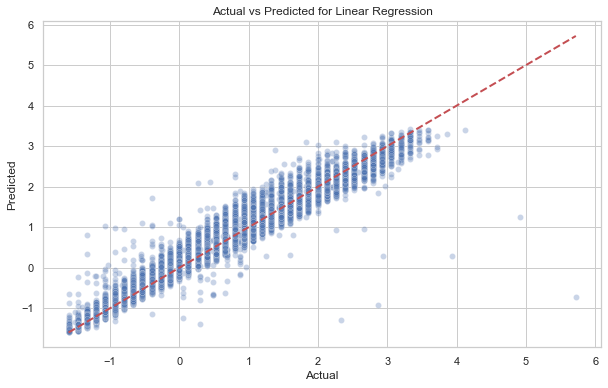

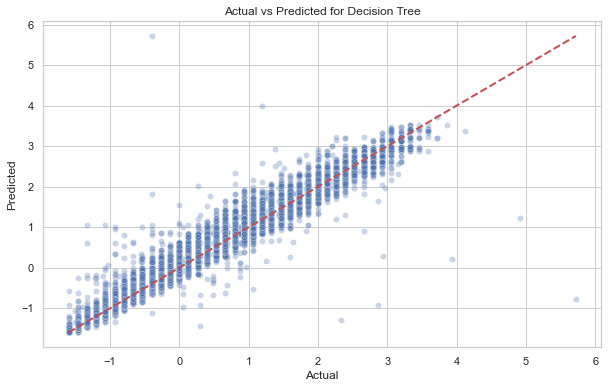

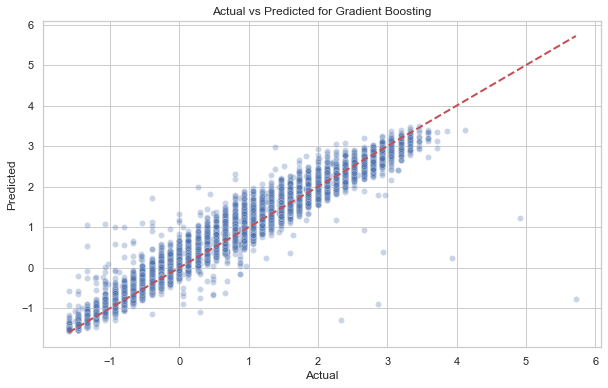

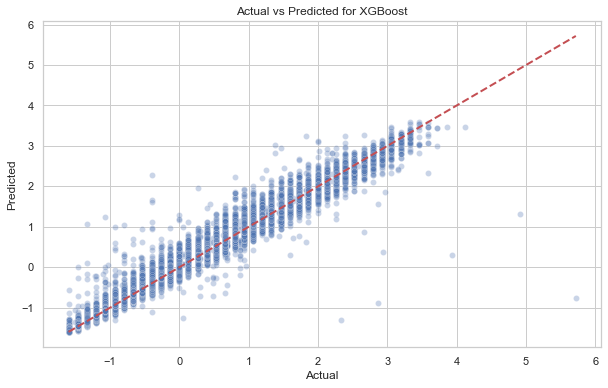

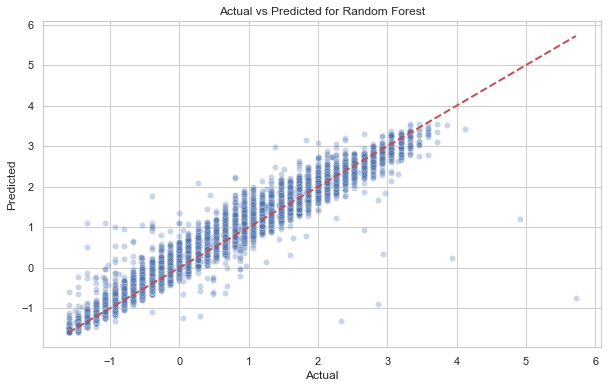

In [51]:
# Linear Regression
plot_actual_vs_predicted(y_test, y_pred_test_linear, 'Linear Regression')

# Decision Tree
plot_actual_vs_predicted(y_test, y_pred_test_dt, 'Decision Tree')

# Gradient Boosting
plot_actual_vs_predicted(y_test, y_pred_test_gb, 'Gradient Boosting')

# XGBoost
plot_actual_vs_predicted(y_test, y_pred_test_xgb, 'XGBoost')

# Random Forest
plot_actual_vs_predicted(y_test, y_pred_test_rf, 'Random Forest')

# Residuals Analysis

In [52]:
# Calculate residuals
residuals_linear = y_test - y_pred_test_linear
residuals_dt = y_test - y_pred_test_dt
residuals_gb = y_test - y_pred_test_gb
residuals_xgb = y_test - y_pred_test_xgb
residuals_rf = y_test - y_pred_test_rf


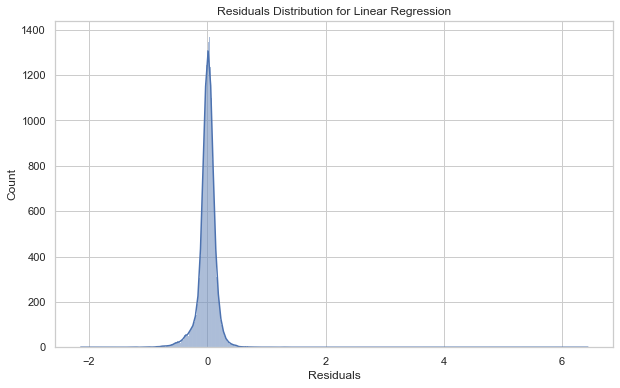

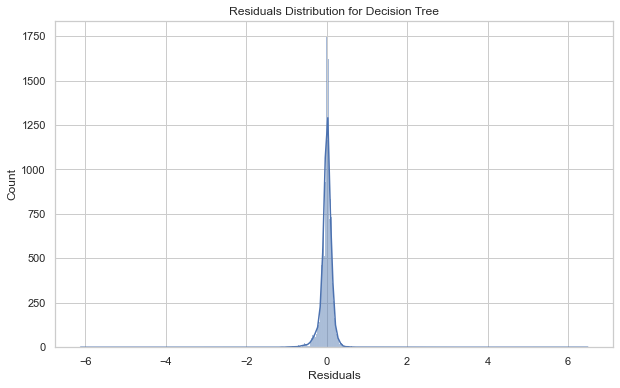

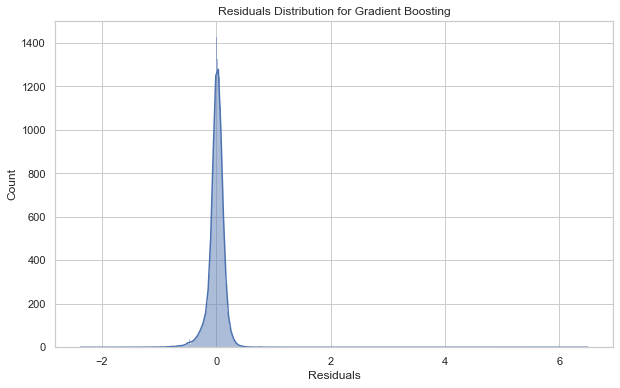

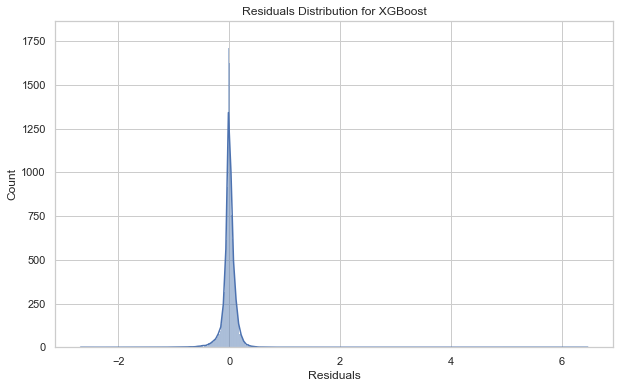

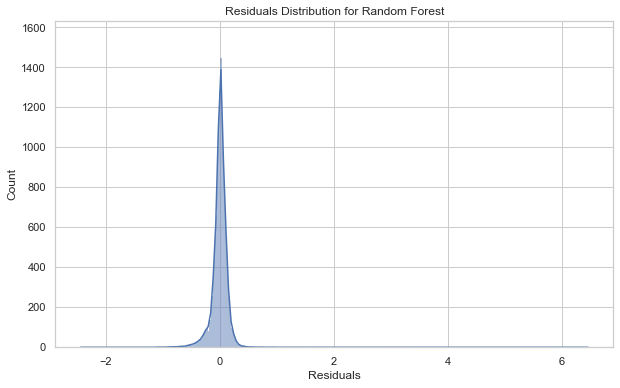

In [53]:


# Plot residuals for each model
plot_residuals(y_test, residuals_linear, 'Linear Regression')
plot_residuals(y_test, residuals_dt, 'Decision Tree')
plot_residuals(y_test, residuals_gb, 'Gradient Boosting')
plot_residuals(y_test, residuals_xgb, 'XGBoost')
plot_residuals(y_test, residuals_rf, 'Random Forest')


In [54]:
# Collect performance metrics for the test set
test_mae = [
    mean_absolute_error(y_test, y_pred_test_linear),
    mean_absolute_error(y_test, y_pred_test_dt),
    mean_absolute_error(y_test, y_pred_test_rf),
    mean_absolute_error(y_test, y_pred_test_gb),
    mean_absolute_error(y_test, y_pred_test_xgb)
]

test_r2 = [
    r2_score(y_test, y_pred_test_linear),
    r2_score(y_test, y_pred_test_dt),
    r2_score(y_test, y_pred_test_rf),
    r2_score(y_test, y_pred_test_gb),
    r2_score(y_test, y_pred_test_xgb)
]

# Create a DataFrame to summarize test performance
test_performance_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Test MAE': test_mae,
    'Test R²': test_r2
})

print(test_performance_df)


               Model  Test MAE   Test R²
0  Linear Regression  0.098828  0.974999
1      Decision Tree  0.094867  0.974987
2      Random Forest  0.087992  0.978543
3  Gradient Boosting  0.094843  0.976926
4            XGBoost  0.075392  0.980994


# Ensemble Model 

An ensemble model combines multiple machine learning models to improve predictive performance. The idea is to leverage the strengths of different models and mitigate their individual weaknesses. In your case, the ensemble model is built using VotingRegressor, which combines predictions from several regressors, including LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, and XGBRegressor.



In [55]:
from sklearn.ensemble import VotingRegressor

# Initialize the models
linear_model = LinearRegression()
dt_model = DecisionTreeRegressor(max_depth=best_dt_model.get_params()['max_depth'])
rf_model = RandomForestRegressor(**best_rf_model.get_params())
gb_model = GradientBoostingRegressor(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10)
xgb_model = best_xgb_model



In [56]:
# Create an ensemble model
ensemble_model = VotingRegressor(
    estimators=[
        ('lr', linear_model),
        ('dt', dt_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ]
)

In [57]:
# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('dt', DecisionTreeRegressor(max_depth=10)),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   min_samples_split=5,
                                                   n_estimators=50,
                                                   random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(n_iter_no_change=10)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                

In [58]:
# Evaluate the ensemble model
y_pred_val_ensemble = ensemble_model.predict(X_val)
print("Ensemble Model Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_ensemble))
print("Validation R²:", r2_score(y_val, y_pred_val_ensemble))


Ensemble Model Performance
Validation MAE: 0.08553916786763911
Validation R²: 0.9800866172241749


In [59]:
# Ensemble model testing
y_pred_test_ensemble = ensemble_model.predict(X_test)

In [60]:
# Ensemble Model Testing
print("\nRandom Forest")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))



Random Forest
Test MAE: 0.08799197203882446
Test R²: 0.9785426355180706


We can see that model performs well on test set alike from its scores.

# Comparing Ensemble Model To Other models

In [61]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost','Ensemble']
val_mae = [
    mean_absolute_error(y_val, y_pred_val),
    mean_absolute_error(y_val, y_pred_val_dt),
    mean_absolute_error(y_val, y_pred_val_rf),
    mean_absolute_error(y_val, y_pred_val_gb),
    mean_absolute_error(y_val, y_pred_val_xgb),
    mean_absolute_error(y_val, y_pred_val_ensemble)
    
    
]
val_r2 = [
    r2_score(y_val, y_pred_val),
    r2_score(y_val, y_pred_val_dt),
    r2_score(y_val, y_pred_val_rf),
    r2_score(y_val, y_pred_val_gb),
    r2_score(y_val, y_pred_val_xgb),
     r2_score(y_val, y_pred_val_ensemble)
   
]

performance_df = pd.DataFrame({
    'Model': models,
    'Validation MAE': val_mae,
    'Validation R²': val_r2
})

print(performance_df)



               Model  Validation MAE  Validation R²
0  Linear Regression        0.098265       0.975488
1      Decision Tree        0.093592       0.976411
2      Random Forest        0.087527       0.979220
3  Gradient Boosting        0.094095       0.977620
4            XGBoost        0.074745       0.982546
5           Ensemble        0.085539       0.980087


In [62]:
# Collect performance metrics for the test set
test_mae = [
    mean_absolute_error(y_test, y_pred_test_linear),
    mean_absolute_error(y_test, y_pred_test_dt),
    mean_absolute_error(y_test, y_pred_test_rf),
    mean_absolute_error(y_test, y_pred_test_gb),
    mean_absolute_error(y_test, y_pred_test_xgb),
    mean_absolute_error(y_test, y_pred_test_rf)
]

test_r2 = [
    r2_score(y_test, y_pred_test_linear),
    r2_score(y_test, y_pred_test_dt),
    r2_score(y_test, y_pred_test_rf),
    r2_score(y_test, y_pred_test_gb),
    r2_score(y_test, y_pred_test_xgb),
    r2_score(y_test, y_pred_test_rf)
]

# Create a DataFrame to summarize test performance
test_performance_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost','Ensemble Model'],
    'Test MAE': test_mae,
    'Test R²': test_r2
})

print(test_performance_df)

               Model  Test MAE   Test R²
0  Linear Regression  0.098828  0.974999
1      Decision Tree  0.094867  0.974987
2      Random Forest  0.087992  0.978543
3  Gradient Boosting  0.094843  0.976926
4            XGBoost  0.075392  0.980994
5     Ensemble Model  0.087992  0.978543


# Model Performance Analysis

This analysis evaluates the performance of various models based on Test and Validation Mean Absolute Error (MAE) and R² scores. The goal is to determine which model is best suited for test and prediction data.


### Observations

1. **Lowest MAE**: XGBoost has the lowest Test MAE (0.075392), indicating it makes the smallest average prediction errors.
2. **Highest R²**: XGBoost also has the highest Test R² (0.980994), suggesting it explains the most variance in the data.
3. **Close Performers**: Random Forest and the Ensemble Model show identical Test MAE (0.087992) and R² (0.978543), both performing well but not as well as XGBoost.


### Observations

1. **Lowest MAE**: XGBoost again has the lowest Validation MAE (0.074745), confirming its robustness and accuracy.
2. **Highest R²**: XGBoost also maintains the highest Validation R² (0.982546), indicating strong consistency in explaining data variance.
3. **Close Performers**: The Ensemble Model follows closely with a Validation MAE of 0.085539 and R² of 0.980087.

## Conclusion

Based on both Test and Validation data:

- **Best Model**: **XGBoost** is the best performing model, achieving the lowest MAE and highest R² scores in both Test and Validation datasets.
- **Runner-Up**: The Ensemble Model and Random Forest are also strong contenders, with very close performance metrics.

Therefore, for both test and prediction data, **XGBoost** is recommended due to its superior accuracy and consistency.

## Feature Importance For Best Performing Model

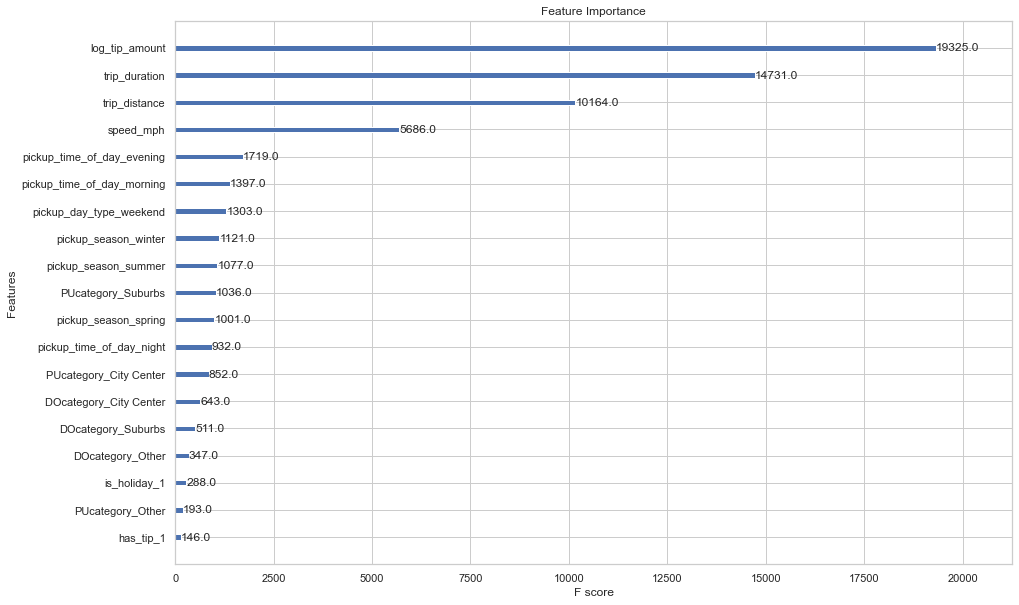

In [63]:
# Assuming `best_xgb_model` is your trained XGBoost model
fig, ax = plt.subplots(figsize=(15, 10))  # Set the figure size
xgb.plot_importance(best_xgb_model, importance_type='weight', ax=ax)
plt.title('Feature Importance')
plt.show()

We see that for the best performing model tip amount trip duration and distance had the highest weights which is not surprising. It is also interesting to see how weights varied for categorical features as well.

## XGboost Model Croos Validation

In [64]:

# Perform cross-validation for the best XGBoost model
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='neg_mean_absolute_error')

print("Cross-Validation MAE Scores:", -cv_scores)
print("Mean Cross-Validation MAE:", -cv_scores.mean())


Cross-Validation MAE Scores: [0.07354666 0.07554334 0.07534492 0.07414616 0.07492192]
Mean Cross-Validation MAE: 0.07470059880774912




### Cross-Validation MAE Scores

The Cross-Validation MAE (Mean Absolute Error) scores are:
- 0.07354666
- 0.07554334
- 0.07534492
- 0.07414616
- 0.07492192

### Analysis of Individual Scores

Each of these scores represents the MAE obtained from one fold of the cross-validation. In k-fold cross-validation, the data is split into k subsets (folds). The model is trained on \( k-1 \) folds and tested on the remaining fold. This process is repeated k times, with each fold serving as the test set once.

- **Consistency**: The scores are quite close to each other, indicating that the model's performance is consistent across different subsets of the data.
- **Error Metric**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

### Mean Cross-Validation MAE

The Mean Cross-Validation MAE is the average of the individual MAE scores:
\[ \text{Mean Cross-Validation MAE} = 0.07470059880774912 \]

### Interpretation

- **General Performance**: The mean MAE of approximately 0.0747 indicates the model, on average, makes errors of around 0.0747 in the units of the target variable. This value gives a single summary statistic of the model's performance.
- **Model Reliability**: Given that the individual MAE scores are close to the mean, this suggests that the model is reliable and performs consistently across different data splits.
- **Model Selection**: When comparing models, the one with the lower mean cross-validation MAE is generally preferred, as it indicates better average performance in terms of prediction accuracy.

### Conclusion

The provided CV scores and the mean MAE suggest that the model performs consistently and has a relatively low average error. This consistency and low error are desirable properties in a predictive model, indicating it is likely to perform well on unseen data.

# Summary 

# Saving The XGboost Model 

In [71]:
import joblib
# Save the best XGBoost model
joblib.dump(best_xgb_model, 'xgboost_model_final.pkl')

['xgboost_model_final.pkl']

### Summary of the Jupyter Notebook: Taxi Fare Prediction Modeling

#### Introduction
The goal of this notebook is to develop a predictive model for taxi fares using the NYC yellow taxi trip dataset from 2023. The model aims to identify key factors influencing fare amounts and leverage machine learning techniques to create a model that accurately estimates fares. The ultimate aim is to provide a structured fare system for Tbilisi, Georgia.

#### Exploratory Data Analysis (EDA) Insights and Hypotheses
**Key Insights:**
1. Fare amount, trip distance, trip duration, speed, and tip amount distributions are highly right-skewed.
2. Fare amount has strong positive correlations with trip distance and trip duration.
3. Time of day, day type, season, and holidays significantly impact fare amounts.
4. Proper handling of outliers is crucial for accurate model predictions.

**Hypotheses:**
1. Longer trip distances and durations result in higher fares.
2. Fares vary by time of day, day of the week, and season, with peaks during special events and holidays.
3. Higher average speeds may correlate with higher fares due to longer distances covered in shorter times.
4. Higher fares tend to receive higher tips.

#### Data Preprocessing
**Data Loading and Cleaning:**
- Loaded the dataset from a Parquet file.
- Removed outliers using the IQR method.
- Observed successful outlier removal through visualizations.

**Feature Transformation:**
- Applied Box-Cox transformation to trip durations and log transformations to other numerical features to handle skewness.
- Created binary features for tip amounts and handled zero tips separately.
- Used RobustScaler and log transformations for features like tip amount and trip distance.

**Categorical Feature Encoding:**
- Categorical features such as `pickup_time_of_day`, `pickup_day_type`, `pickup_season`, `is_holiday`, `PUcategory`, `DOcategory`, and `has_tip` were one-hot encoded.
- Transformed features were concatenated with the dataset, ensuring memory efficiency and better model predictions.

**Feature Scaling:**
- Applied StandardScaler to numerical features to standardize the data.

#### Model Training and Evaluation
**Splitting Data:**
- The dataset was split into training, validation, and test sets.

**Model Training:**
- Various models were trained including Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
- Hyperparameters for Decision Tree, Random Forest, and XGBoost were tuned using Grid Search and Randomized Search.

**Performance Metrics:**
- Models were evaluated based on Mean Absolute Error (MAE) and R² scores.
- The XGBoost model outperformed others with the lowest Validation MAE (0.074745) and the highest Validation R² (0.982546).

**Ensemble Modeling:**
- An ensemble model was created using VotingRegressor, combining predictions from Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
- The ensemble model showed competitive performance, closely following XGBoost.

**Model Testing:**
- Final testing on the test set confirmed that XGBoost had the best performance with a Test MAE of 0.075392 and Test R² of 0.980994.
- The ensemble model and Random Forest also performed well but not as well as XGBoost.

#### Feature Importance and Cross-Validation
**Feature Importance:**
- Analyzed feature importance for the best performing model (XGBoost). Tip amount, trip duration, and distance had the highest weights.

**Cross-Validation:**
- Conducted cross-validation for XGBoost. The mean cross-validation MAE was approximately 0.0747, indicating consistent model performance across different data splits.

#### Conclusion
**Best Model:**
- XGBoost is identified as the best model due to its superior accuracy and consistency in both validation and test datasets.
- The ensemble model and Random Forest are also strong contenders with very close performance metrics.

#### Saving the Model
- Saved the best XGBoost model and the preprocessing pipeline using joblib for future use.

This notebook effectively demonstrates the entire process of building a predictive model for taxi fares, from data preprocessing and feature transformation to model training, evaluation, and selection, concluding with the saving of the best model for deployment.